In [1]:
import torch
from transformers import CLIPModel, CLIPProcessor
from diffusers import DiffusionPipeline
from diffusers.utils import load_image


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
{'tokenizer', 'decoder', 'decoder_scheduler', 'text_proj', 'super_res_last', 'super_res_first', 'image_encoder', 'text_encoder', 'feature_extractor', 'super_res_scheduler'} - {'tokenizer', 'decoder', 'decoder_scheduler', 'text_proj', 'super_res_last', 'text_encoder', 'super_res_first', 'super_res_scheduler'}


{'feature_extractor', 'image_encoder'}

In [3]:
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [4]:
urls = [
  "http://images.cocodataset.org/val2017/000000039769.jpg",
  "https://farm3.staticflickr.com/2674/5850229113_4fe05d5265_z.jpg",
]
images = [load_image(url) for url in urls]

texts = ["dog", "cat"]
inputs = processor(text=texts, images=images, return_tensors="pt", padding=True)

with torch.no_grad():
  outputs = model(**inputs)


In [8]:
inputs["pixel_values"].shape


torch.Size([2, 3, 224, 224])

In [5]:
outputs.text_embeds.shape


torch.Size([2, 768])

In [67]:
image_embeds = outputs.text_embeds[0].to("cuda").half().unsqueeze(0)
image_embeds.shape


torch.Size([1, 768])

In [78]:
import torch
from diffusers import UnCLIPScheduler, DDPMScheduler, StableUnCLIPPipeline
from diffusers.models import PriorTransformer
from transformers import CLIPTokenizer, CLIPTextModelWithProjection

prior_model_id = "kakaobrain/karlo-v1-alpha"
data_type = torch.float16
prior = PriorTransformer.from_pretrained(prior_model_id, subfolder="prior", torch_dtype=data_type)

prior_text_model_id = "openai/clip-vit-large-patch14"
prior_tokenizer = CLIPTokenizer.from_pretrained(prior_text_model_id)
prior_text_model = CLIPTextModelWithProjection.from_pretrained(prior_text_model_id, torch_dtype=data_type)
prior_scheduler = UnCLIPScheduler.from_pretrained(prior_model_id, subfolder="prior_scheduler")
prior_scheduler = DDPMScheduler.from_config(prior_scheduler.config)

stable_unclip_model_id = "stabilityai/stable-diffusion-2-1-unclip-small"

pipe = StableUnCLIPPipeline.from_pretrained(
    stable_unclip_model_id,
    torch_dtype=data_type,
    variant="fp16",
    prior_tokenizer=prior_tokenizer,
    prior_text_encoder=prior_text_model,
    prior=prior,
    prior_scheduler=prior_scheduler,
)

pipe = pipe.to("cuda")


/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_utils.py:1695: FutureWarning: You are trying to load the model files of the `variant=fp16`, but no such modeling files are available.The default model files: {'image_normalizer/diffusion_pytorch_model.safetensors', 'image_encoder/pytorch_model.bin', 'image_normalizer/diffusion_pytorch_model.bin', 'unet/diffusion_pytorch_model.safetensors', 'text_encoder/pytorch_model.bin', 'unet/diffusion_pytorch_model.bin', 'vae/diffusion_pytorch_model.bin', 'image_encoder/model.safetensors', 'vae/diffusion_pytorch_model.safetensors', 'text_encoder/model.safetensors'} will be loaded instead. Make sure to not load from `variant=fp16`if such variant modeling files are not available. Doing so will lead to an error in v0.24.0 as defaulting to non-variantmodeling files is deprecated.
  deprecate("no variant default", "0.24.0", deprecation_message, standard_warn=False)
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  9.9

100%|██████████| 21/21 [00:00<00:00, 21.67it/s]


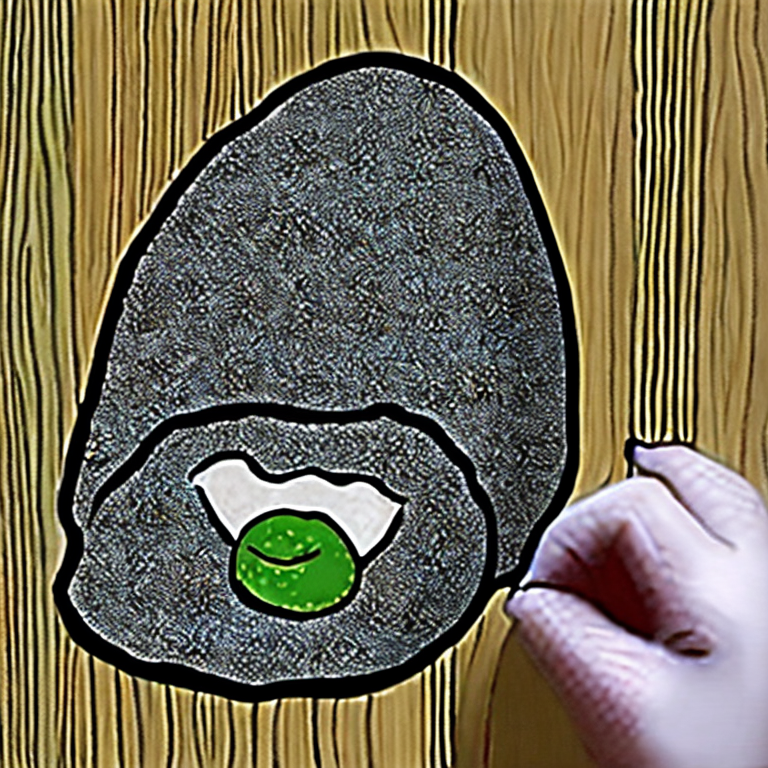

In [85]:
wave_prompt = "A man with a face of avocado, in the drawing style of Rene Magritte"

images = pipe(prompt=wave_prompt).images
images[0]


super_res_first/config.json: 100%|██████████| 857/857 [00:00<00:00, 6.76MB/s]
decoder/config.json: 100%|██████████| 1.10k/1.10k [00:00<00:00, 12.9MB/s]
text_proj/config.json: 100%|██████████| 203/203 [00:00<00:00, 2.23MB/s]

tokenizer/special_tokens_map.json: 100%|██████████| 460/460 [00:00<00:00, 4.35MB/s]

tokenizer/tokenizer_config.json: 100%|██████████| 818/818 [00:00<00:00, 8.17MB/s]
tokenizer/merges.txt: 100%|██████████| 525k/525k [00:00<00:00, 1.84MB/s]















tokenizer/vocab.json: 100%|██████████| 1.06M/1.06M [00:00<00:00, 1.65MB/s]



































diffusion_pytorch_model.safetensors: 100%|██████████| 31.5M/31.5M [00:33<00:00, 934kB/s]

































































































































































































































































































































